In [ ]:
from strikepoint.driver import LeptonDriver
from strikepoint.producer import FrameProducer
from strikepoint.frames import FrameInfo, FrameInfoReader
from IPython.display import Image, display
from picamera2 import Picamera2
import numpy as np

import cv2
import numpy as np



In [ ]:
def showFrame(frame):
    ok, buf = cv2.imencode('.png', frame)
    if not ok:
        raise RuntimeError("Could not encode frame to PNG")
    display(Image(data=buf.tobytes()))


In [ ]:

with Picamera2() as picam:
    with LeptonDriver() as driver:
        picam.start()
        driver.setLogFile('logsFromDevNotebook.log')
        driver.startPolling()
        # TODO: Use Picamera2 to set up the camera properly
        # picam2 = Picamera2()
        producer = FrameProducer(driver, picam)
        frameInfo = producer.getFrameInfo()
        thermRaw = frameInfo.rawFrames['thermal']
        print(f"Min thermal value: {float(np.min(thermRaw))}")
        print(f"Max thermal value: {float(np.max(thermRaw))}")

        frame = np.hstack((frameInfo.rgbFrames['visual'], 
                            frameInfo.rgbFrames['thermal']))
        showFrame(frame)
        # # this is bad, need something to synchronize here
        # showFrame(producer.lastThermalRaw)
        # showFrame(producer.lastThermalDiff)
        # showFrame(producer.lastVisualRaw)
        producer.stop()

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
with FrameInfoReader("demo-three-balls.bin") as reader:
    frameInfoList = list(enumerate(reader.readAllFrameInfo()))
    # (visFrameBase, thermFrameBase, _) = np.hsplit(frameList[0][1], 3)
    # visFrameBase = cv2.cvtColor(visFrameBase, cv2.COLOR_BGR2GRAY)

    for i, frameInfo in frameInfoList[::]:
        visFrame = frameInfo.rgbFrames['visual']
        thermFrame = frameInfo.rgbFrames['thermal']
        print(f"Frame #{i}")
        # showFrame(np.hstack((visFrame, thermFrame)))
        thermalRaw = frameInfo.rawFrames['thermal']
        print(f"Min thermal value: {float(np.min(thermalRaw))}")
        print(f"Max thermal value: {float(np.max(thermalRaw))}")
        # showFrame(thermFrame)
        # visCircles = findTargetCircleCount(visFrame, 1, startRadius=10)
        try:
            # showFrame(thermFrame)
            visDemo, visCircles = \
                FrameProducer.findTargetCircleCount(visFrame, 3)
            thermDemo, thermCircles = \
                FrameProducer.findTargetCircleCount(thermFrame, 3)
            showFrame(np.hstack((visDemo, thermDemo)))
        except RuntimeError as ex:
            # print(f"NOT Frame #{i}")
            continue

Frame #140


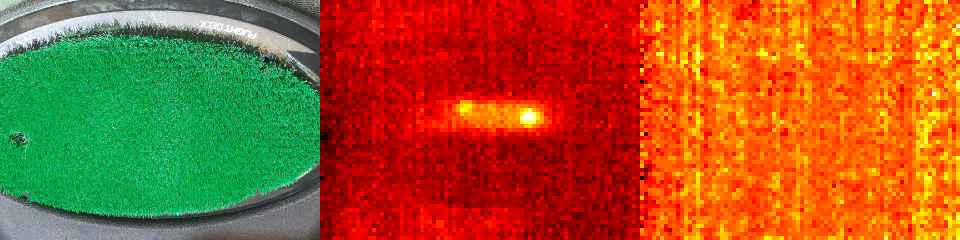

Frame #141


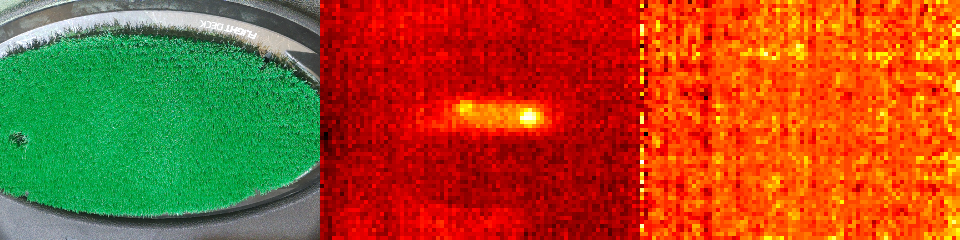

Frame #142


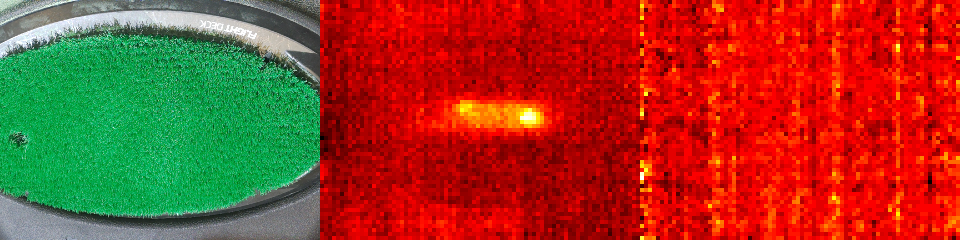

Frame #143


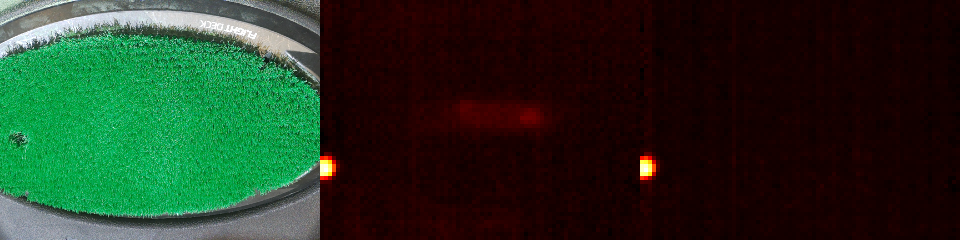

Frame #144


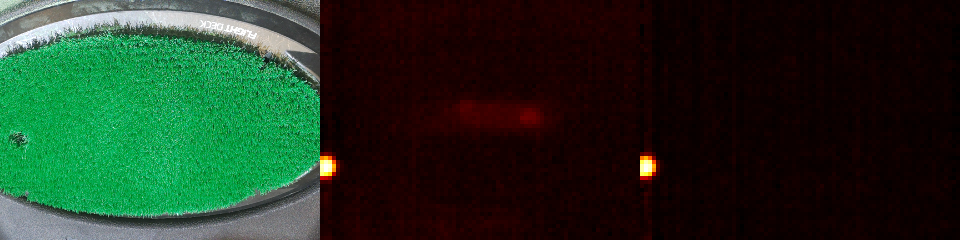

Frame #145


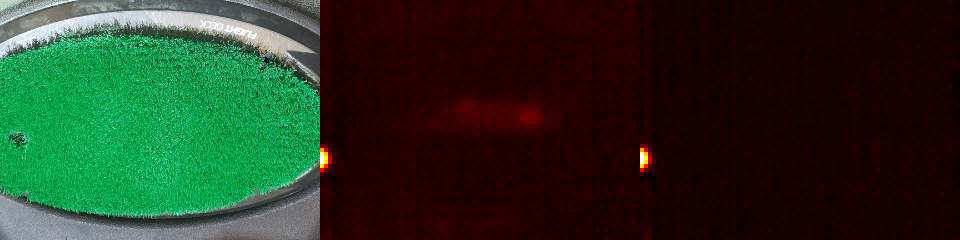

Frame #146


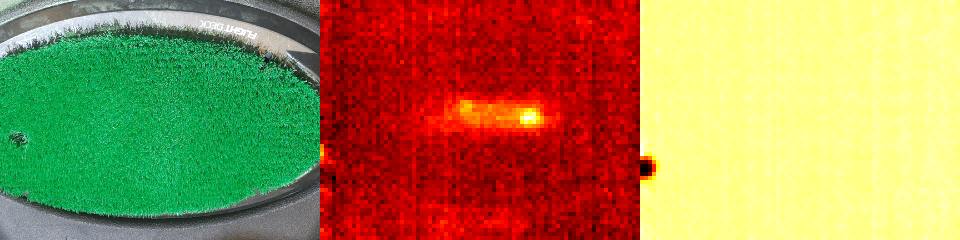

Frame #147


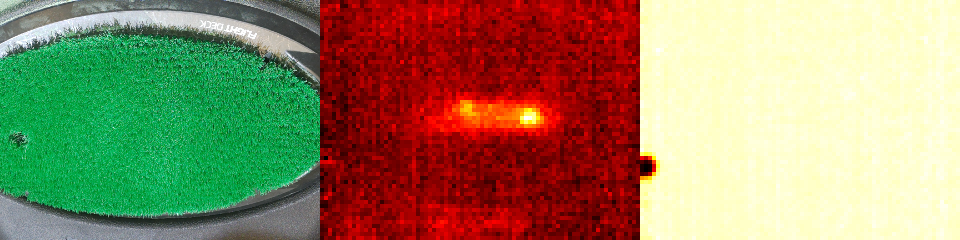

Frame #148


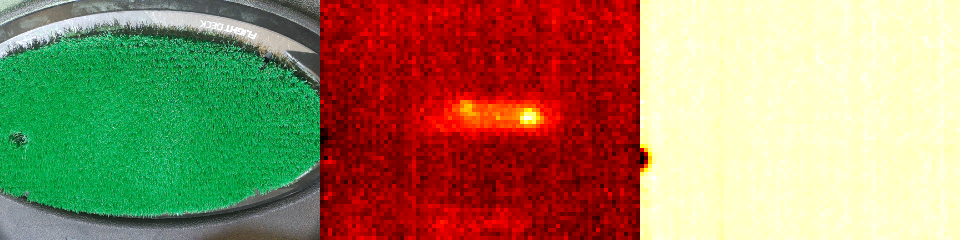

Frame #149


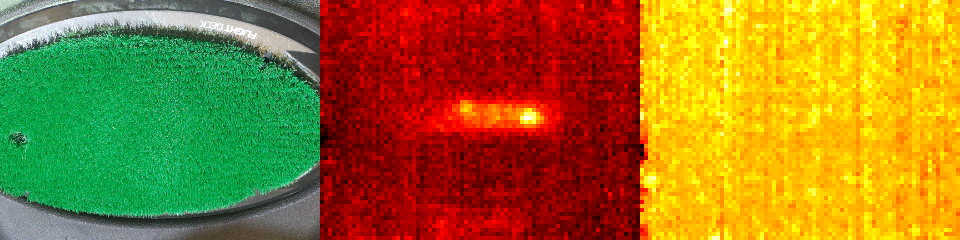

In [ ]:
from strikepoint.frames import FrameInfoReader
import numpy as np
import cv2


with FrameInfoReader("demo-three-hits.bin") as reader:
    frameInfoList = list(enumerate(reader.readAllFrameInfo()))

    lookback=8
    for i, frameInfo in frameInfoList[lookback:]:
        print(f"Frame #{i}")
        visFrame = frameInfo.rgbFrames['visual']
        thermFrame = frameInfo.rgbFrames['thermal']

        frame = frameInfo.rawFrames['thermal'] - \
            frameInfoList[i-lookback+1][1].rawFrames['thermal']
        frame = cv2.flip(frame, 0)
        frame = cv2.flip(frame, 1)
        frame = cv2.resize(frame, (320, 240),
                            interpolation=cv2.INTER_NEAREST)
        frame = cv2.normalize(
            frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        frame = cv2.applyColorMap(frame, cv2.COLORMAP_HOT)
        showFrame(np.hstack((visFrame, thermFrame, frame)))

        # if frameInfo.metadata.get('hasBall', True):
        #     thermDemo, thermCircles = \
        #         FrameProducer.findTargetCircleCount(thermFrame, 1)
        # else:
        #     showFrame(np.hstack((visFrame, thermFrame)))



        # ballPattern = tuple(f[1].metadata.get('hasBall', False) 
        #                for f in frameInfoList[i-3:i+1])
        # if ballPattern == (True, True, False, False):
        #     for f in frameInfoList[i-3:i+1]:
        #         visFrame = f[1].rgbFrames['visual']
        #         thermFrame = f[1].rgbFrames['thermal']
        #         showFrame(np.hstack((visFrame, thermFrame)))
            # visCircles = findTargetCircleCount(visFrame, 1, startRadius=10)
            # try:
            #     # showFrame(thermFrame)
            #     visDemo, visCircles = \
            #         FrameProducer.findTargetCircleCount(visFrame, 1)
            #     showFrame(visDemo)
            # except RuntimeError as ex:
            #     # print(f"NOT Frame #{i}")
            #     continue